# Ch 2. Generalized Linear Models

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

## Generalized linear models

## Logistic regression

- GLM with a *logistic function* for the inverse link function
    - the output for any input $z$ will lie within the 0 and 1 interval
    - thus, transforms data for a Bernoulli distribution

$$
\text{logistic}(z) = \frac{1}{1 + e^{-z}}
$$

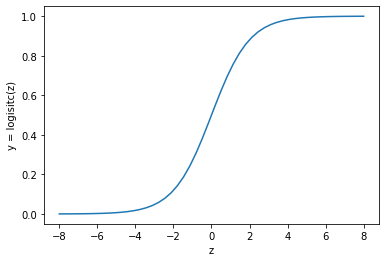

In [3]:
z = np.linspace(-8, 8)
y = 1 / (1 + np.exp(-z))
plt.plot(z, y)
plt.xlabel("z")
plt.ylabel("y = logisitc(z)")
plt.show()

### The logistic model

- same as a linear regression, just using the logistic link function and the Bernoulli likelihood function

$$
\theta = logistic(\alpha + x \beta) \\
y \sim \text{Bernoulli}(\theta)
$$

### The Iris dataset

In [4]:
iris = pd.read_csv("data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


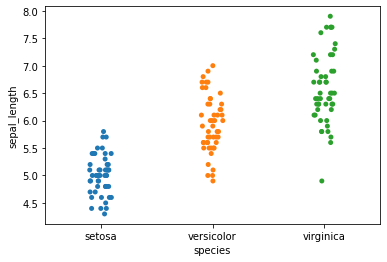

In [6]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.show()

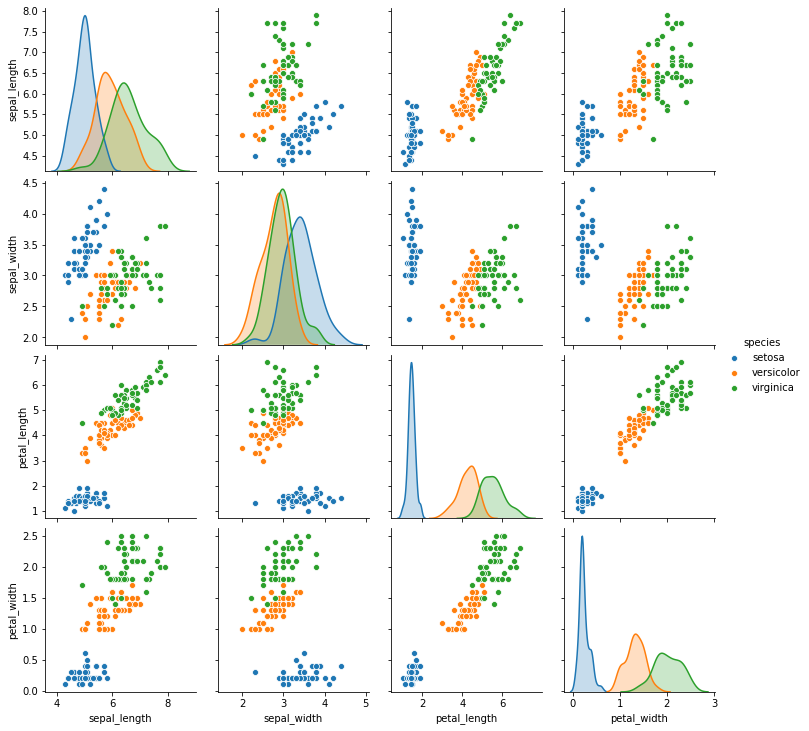

In [8]:
sns.pairplot(iris, hue="species", diag_kind="kde")
plt.show()

#### The logistic model applied to the Iris dataset